# Notebook settings
This notebook is a universal frame for training the DistilBERT+Linearmodel. It can take in any Parquet dataset with suitable configuration.

In [1]:
### Dataset configuration
# The parquet folder. It should be located inside datasets/.
DATASET_NAME   = 'Electronics.parquet'
# The input text column
TEXT_COL_NAME  = 'title'
# Which column to use as labelled classes. It should be a column of lists of strings.
CLASS_COL_NAME = 'category'
# How many hierarchical levels to work on. Note that the dataset must also have at least this many levels for every example.
DEPTH = 2 

### Checkpoint configuration
# Whether to train from scratch or to load a checkpoint
TRAIN_FROM_SCRATCH=True
# Checkpoint iteration to load if not training from scratch
LOAD_ITERATION=0
# Last or best results from that iteration?
LOAD_BEST=True

### System configuration
# Will try to use your NVIDIA GPU if one is available. Set to False to force CPU computation
PREFER_GPU         = True
# If you don't have the huggingface transformers library installed, flip this to True.
# You only need to do this once. Once DistilBERT has been downloaded, it will be cached in your system's default user cache folder.
# Once it is cached, please set this to False to avoid redownloads.
INSTALL_DISTILBERT = False

# Import common libraries
And also set up a few things.

In [2]:
import dask.dataframe as dd
import numpy as np
import torch
from tqdm.notebook import tqdm
import numpy as np
import shutil, sys
from sklearn import metrics
import os

# Set up GPU if available
device = 'cuda' if torch.cuda.is_available() and PREFER_GPU else 'cpu'
print('Using', device)

Using cuda


# Import data

In [3]:
data = dd.read_parquet('../../datasets/{}'.format(DATASET_NAME))
data.head(10)

,category,title,description,brand,feature
index,,,,,
0,"[Camera & Photo, Video Surveillance, Surveilla...",Genuine Geovision 1 Channel 3rd Party NVR IP S...,The following camera brands and models have be...,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ..."
1,"[eBook Readers & Accessories, eBook Readers]",One Hot Summer,A zesty tale. (Publishers Weekly)<br /><br />G...,Visit Amazon's Carolina Garcia Aguilera Page,[]
2,"[eBook Readers & Accessories, eBook Readers]",sex.lies.murder.fame.: A Novel,“sex.lies.murder.fame. is brillllli—f@#*ing—an...,Visit Amazon's Lolita Files Page,[]
3,"[eBook Readers & Accessories, eBook Readers]",Girl with a One-track Mind: Confessions of the...,GIRL WITH A ONE-TRACK MIND: CONFESSIONS OF THE...,ABBY LEE,[]
4,"[eBook Readers & Accessories, eBook Readers]",The Last Life: A Novel,Claire Messud's piercing second novel asks que...,Visit Amazon's Claire Messud Page,[]
5,"[eBook Readers & Accessories, eBook Readers]",Lady Lazarus,"In this gleeful, difficult debut, Altschul lay...",Visit Amazon's Andrew Foster Altschul Page,[]
6,"[Computers & Accessories, Computer Accessories...",SAMSUNG Evo Plus 64 GB MicroSDXC Class 10 80 M...,"Brand SAMSUNG Speed 80 MB/s Read Speed, 20 Wri...",Samsung,[64 GB MicroSDHC Memory Card Class 10 Memory C...
7,"[Camera & Photo, Accessories, Blank Video Media]",TDK Hi8 MP120 Premium Performance Camcorder Vi...,TDK Hi8 MP120 Premium Performance Camcorder Vi...,TDK Electronics Corp,[]
8,"[eBook Readers & Accessories, eBook Readers]",The Angel Doll: A Christmas Story,"YA?Life in Thomasville, NC, in the 1950s is no...",Visit Amazon's Jerry Bledsoe Page,[]


# Categorical-encode the classes
DistilBERT+Linear only classifiers the leaf level. No hierarchy yet. Also, we'll be using a linear layer in PyTorch, which necessitates us to encode these classes manually.

The reason we're not using one-hot encoding is because we're about to use PyTorch's cross-entropy loss implementation, which only needs indices.

For categorical encoding to work, the column itself must be in Dask's `category` datatype, instead of the default `object` type for non-numerical columns.

In [4]:
data['targets'] = data[CLASS_COL_NAME].apply(
    lambda lst: lst[min(DEPTH-1, len(lst)-1)], meta=(CLASS_COL_NAME, 'object')
).astype('category').cat.as_known()

data['codes'] = data['targets'].cat.codes

Keep a mapping between category code and category names (in strings) so we can get human-readable predictions later.

In [5]:
cls2idx = dict([
    (cls, index) 
    for (index, cls) 
    in enumerate(data['targets'].cat.categories)
])
idx2cls = list(data['targets'].cat.categories)

print('Class-index mapping:', cls2idx)
print('Index-class mapping:', idx2cls)

Class-index mapping: {'AV Receivers & Amplifiers': 0, 'Accessories': 1, 'Analog-to-Digital (DTV) Converters': 2, 'Armbands': 3, 'Audio & Video Accessories': 4, 'Aviation Electronics': 5, 'Bags & Cases': 6, 'Barking-Dog Alarms': 7, 'Batteries & Battery Packs': 8, 'Batteries, Chargers & Accessories': 9, 'Binoculars & Scopes': 10, 'Biometrics': 11, 'Blank Media': 12, 'Blu-ray Players & Recorders': 13, 'Bluetooth & FM Transmitters': 14, 'Boomboxes': 15, 'Bundles': 16, 'CB & Two-Way Radios': 17, 'Cables': 18, 'Car Electronics': 19, 'Cases': 20, 'Cassette Player Adapters': 21, 'Cassette Players & Recorders': 22, 'Chargers & Power Adapters': 23, 'Clips, Arm & Wristbands': 24, 'Compact Radios & Stereos': 25, 'Computer Accessories & Peripherals': 26, 'Computer Components': 27, 'Computers & Tablets': 28, 'Cord Management': 29, 'Covers': 30, 'DVD Players & Recorders': 31, 'DVD-RW Discs': 32, 'DVD-VCR Combos': 33, 'Data Storage': 34, 'Digital Cameras': 35, 'Digital Voice Recorders': 36, 'Earbud He

Also keep the number of leaves for later model construction.

In [6]:
leaf_count = len(cls2idx)

Now we can generate our custom-ordered, global binary encoding.

$|Y_L^h|$ can easily be sliced from the global encoding by relying on the backed-up per-level class counts.

# Data and model preparation

## Installing DistilBERT
Alternative to full-fat BERT, roughly matching its performance while being faster.

In [7]:
if not INSTALL_DISTILBERT:
    os.environ['TRANSFORMERS_OFFLINE'] = '1'
else:
    !pip install transformers
    
import transformers as ppb
tokenizer = ppb.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_encoder = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
base_encoder_state = base_encoder.state_dict()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Checkpoints

In [8]:
def load_checkpoint(checkpoint_fpath, model, optimizer=None):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer
    return model

def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model (min validation lost)
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

## Define our dataset adapter class
This wraps around our data and provides a PyTorch-compatible interface.

In [9]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self, df, tokenizer, max_len):
    self.tokenizer = tokenizer
    # TODO: Make these customisable from the constructor interface
    self.text = df[TEXT_COL_NAME]
    self.labels = df['codes']
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text.iloc[index])
    text = " ".join(text.split())
    inputs = self.tokenizer(
      text,
      None, # No text_pair
      add_special_tokens=True, # CLS, SEP
      max_length=self.max_len, # For us it's a hyperparam. See next cells.
      padding='max_length',
      truncation=True
      # BERT tokenisers return attention masks by default
    )
    return {
      'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
      'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
      'labels': torch.tensor(self.labels.iloc[index], dtype=torch.float)
    }

Regarding that `max_len` hyperparameter, let's see the text lengths' distribution:

/usr/lib/python3.9/site-packages/dask/dataframe/core.py:3718: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('title', 'int64'))

  warnings.warn(meta_warning(meta))


<AxesSubplot:>

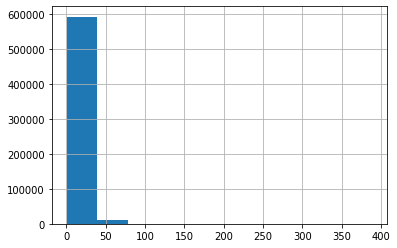

In [10]:
data[TEXT_COL_NAME].apply(lambda s: len(s.split())).compute().hist()

We prefer `max_len` to be a power of two that covers most of the strings. Here it seems 64 will do.

In [11]:
###
### TUNING HYPERPARAMETERS?
### Simply adjust here then run this cell and those below it. No need to run those above.
###

folder_name = 'checkpoints-' + DATASET_NAME
!mkdir $folder_name
CHECKPOINT_IDX = len(os.listdir(folder_name)) // 2
CHECKPOINT_PATH = './{}/{}_current.pt'.format(folder_name, CHECKPOINT_IDX)
BEST_CHECKPOINT_PATH = './{}/{}_best.pt'.format(folder_name, CHECKPOINT_IDX)

config = {
    'lr': 1e-05,
    'epochs': 5,
    'dropout': 0.25,
}

### Don't change these if you need to compare with published results
MAX_LEN = 64
TRAIN_MINIBATCH_SIZE = 32
VAL_TEST_MINIBATCH_SIZE = 64
TRAIN_SET_RATIO = 0.8
VAL_SET_RATIO = 0.1
# The rest is test set
RANDOM_SEED = 123
# Flip to False for faster hyperparameter tuning. If False, only 5% of the full dataset is used. 
FULL_SET = True

mkdir: cannot create directory ‘checkpoints-Electronics.parquet’: File exists


CV-split our dataset:

In [12]:
small_data = None
if not FULL_SET:
    small_data = data.sample(frac = 0.05, random_state=RANDOM_SEED)

train_set = None
test_set = None

COLUMNS = [TEXT_COL_NAME, 'codes']

filtered = None
if FULL_SET:
    filtered = data[COLUMNS].compute()
else:
    filtered = small_data[COLUMNS].compute()

train_set = filtered.sample(frac = TRAIN_SET_RATIO, random_state=RANDOM_SEED)
val_test_set = filtered.drop(train_set.index)

val_set = val_test_set.sample(frac = VAL_SET_RATIO / (1-TRAIN_SET_RATIO), random_state=RANDOM_SEED)
test_set = val_test_set.drop(val_set.index)

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(481622, 2)
(60203, 2)
(60202, 2)


We can now wrap them in our Datasets, and then into PyTorch's DataLoaders.

In [13]:
train_set_wrapped = CustomDataset(train_set, tokenizer, MAX_LEN)
val_set_wrapped = CustomDataset(val_set, tokenizer, MAX_LEN)
test_set_wrapped = CustomDataset(test_set, tokenizer, MAX_LEN)

train_loader = torch.utils.data.DataLoader(dataset=train_set_wrapped, batch_size=TRAIN_MINIBATCH_SIZE, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=val_set_wrapped, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_set_wrapped, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)

## Prepare the model itself
Here we use DistilBERT as the encoding layers, followed by a dropout layer and a linear layer for leaf category classification.

In [14]:
import torch
from tqdm.notebook import tqdm
from functools import reduce

class DB_Linear(torch.nn.Module):

  def __init__(self, config, output_count):
    super(DB_Linear, self).__init__()
    self.l1 = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
    self.l2 = torch.nn.Dropout(config['dropout'])
    self.l3 = torch.nn.Linear(768, output_count) # DistilBERT outputs 768 values.
    self.output_size = output_count

  def forward(self, ids, mask):
    output_1 = self.l1(ids, attention_mask = mask)[0][:,0,:]
    output_2 = self.l2(output_1)
    output = self.l3(output_2)
    return output

model = DB_Linear(config, leaf_count)

model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DB_Linear(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features=76

Now we define the loss function that we will use to fine-tune our model (DistilBERT included).

For now we'll stick with one of the provided loss functions instead of building anything radical. As we are performing multiclass classification here, we should use Cross Entropy Loss (the normal one for multiclass, not BCE for binary).

We also construct our optimiser here.



# Training time

In [15]:
from sklearn import metrics
def get_metrics(output, targets):
    # Get predicted codes
    predicted_leaf_codes = np.argmax(output, axis=1)

    acc = metrics.accuracy_score(predicted_leaf_codes, targets)
    pre = metrics.precision_score(predicted_leaf_codes, targets, average='weighted', zero_division=0)
    print('Leaf level metrics:')
    print("Accuracy:", acc)
    print("Precision:", pre)
    
    return np.array([acc, pre])

In [16]:
from tqdm.notebook import tqdm

def train_model(config, train_loader, val_loader, model, checkpoint_path, best_checkpoint_path):

  # Store validation metrics after each epoch
  val_metrics = np.empty((2, 0), dtype=float)
    
  criterion = torch.nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])

  val_loss_min = np.Inf
  for epoch in range(1, config['epochs'] + 1):
    train_loss = 0
    val_loss = 0
    # Put model into training mode. Note that this call DOES NOT train it yet.
    model.train()
    print('Epoch {}: Training'.format(epoch))
    for batch_idx, data in enumerate(tqdm(train_loader)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      targets = data['labels'].to(device, dtype = torch.long)

      outputs = model(ids, mask)

      loss = criterion(outputs, targets)

      # PyTorch defaults to accumulating gradients, but we don't need that here
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss = train_loss + (loss.item() - train_loss) / (batch_idx + 1)

    print('Epoch {}: Validation'.format(epoch))
    
    
    # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
    model.eval()

    val_targets = np.array([], dtype=float)
    val_outputs = np.empty((0, model.output_size), dtype=float)

    # We're only testing here, so don't run the backward direction (no_grad).
    with torch.no_grad():
      total_loss = 0
      for batch_idx, data in enumerate(tqdm(val_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.long)

        outputs = model(ids, mask)

        loss = criterion(outputs, targets)

        total_loss += loss

        val_loss = val_loss + (loss.item() - val_loss) / (batch_idx + 1)
        
        val_targets = np.concatenate([val_targets, targets.cpu().detach().numpy()])
        val_outputs = np.concatenate([val_outputs, outputs.cpu().detach().numpy()])

      # calculate average losses
      #print('before cal avg train loss', train_loss)
      print('Average minibatch loss:', total_loss / len(val_loader))
    
      val_metrics = np.concatenate([val_metrics, 
                                    np.expand_dims(get_metrics(val_outputs, val_targets), axis=1)],
                                   axis=1)
      train_loss = train_loss/len(train_loader)
      val_loss = val_loss/len(val_loader)
      # Print training/validation statistics 
      print('Avgerage training loss: {:.6f}\nAverage validation loss: {:.6f}'.format( 
            train_loss,
            val_loss
            ))

      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'val_loss_min': val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
      
      best_yet = False
      if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        # save checkpoint as best model
        best_yet = True
        val_loss_min = val_loss
        
      save_checkpoint(checkpoint, best_yet, checkpoint_path, best_checkpoint_path)
    print('Epoch {}: Done\n'.format(epoch))
  return model, val_metrics

# Alternative: just load from disk
def run_model(model, loader):
  # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
  model.eval()

  all_targets = np.array([], dtype=bool)
  all_outputs = np.empty((0, model.output_size), dtype=float)

  # We're only testing here, so don't run the backward direction (no_grad).
  with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(loader)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      targets = data['labels'].long()

      outputs = model(ids, mask)

      all_targets = np.concatenate([all_targets, targets.numpy()])
      all_outputs = np.concatenate([all_outputs, outputs.cpu().detach().numpy()])
  return {
      'targets': all_targets,
      'outputs': all_outputs,
  }

Epoch 1: Training


  0%|          | 0/15051 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/941 [00:00<?, ?it/s]

Average minibatch loss: tensor(0.6030, device='cuda:0')
Leaf level metrics:
Accuracy: 0.8406391708054416
Precision: 0.8497044729091976
Avgerage training loss: 0.000057
Average validation loss: 0.000641
Validation loss decreased (inf --> 0.000641).  Saving model ...
Epoch 1: Done

Epoch 2: Training


  0%|          | 0/15051 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/941 [00:00<?, ?it/s]

Average minibatch loss: tensor(0.5413, device='cuda:0')
Leaf level metrics:
Accuracy: 0.8549573941497932
Precision: 0.8601446536365734
Avgerage training loss: 0.000037
Average validation loss: 0.000575
Validation loss decreased (0.000641 --> 0.000575).  Saving model ...
Epoch 2: Done

Epoch 3: Training


  0%|          | 0/15051 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/941 [00:00<?, ?it/s]

Average minibatch loss: tensor(0.5202, device='cuda:0')
Leaf level metrics:
Accuracy: 0.8604886799661147
Precision: 0.8652811272948632
Avgerage training loss: 0.000032
Average validation loss: 0.000553
Validation loss decreased (0.000575 --> 0.000553).  Saving model ...
Epoch 3: Done

Epoch 4: Training


  0%|          | 0/15051 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/941 [00:00<?, ?it/s]

Average minibatch loss: tensor(0.5069, device='cuda:0')
Leaf level metrics:
Accuracy: 0.865621314552431
Precision: 0.8689500264428596
Avgerage training loss: 0.000028
Average validation loss: 0.000539
Validation loss decreased (0.000553 --> 0.000539).  Saving model ...
Epoch 4: Done

Epoch 5: Training


  0%|          | 0/15051 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/941 [00:00<?, ?it/s]

Average minibatch loss: tensor(0.5167, device='cuda:0')
Leaf level metrics:
Accuracy: 0.8668338787103633
Precision: 0.8699747407474586
Avgerage training loss: 0.000024
Average validation loss: 0.000549
Epoch 5: Done



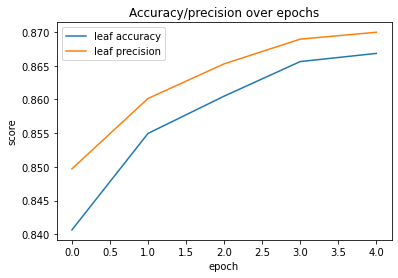

In [17]:
import matplotlib.pyplot as plt

trained_model = None
if TRAIN_FROM_SCRATCH:
    trained_model, val_metrics = train_model(
        config,
        train_loader, 
        val_loader, 
        model,
        CHECKPOINT_PATH,
        BEST_CHECKPOINT_PATH,
    )
    x = np.arange(config['epochs'])
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(x, val_metrics[0], label='leaf accuracy')
    ax.plot(x, val_metrics[1], label='leaf precision')
    ax.set_xlabel('epoch')  # Add an x-label to the axes.
    ax.set_ylabel('score')  # Add a y-label to the axes.
    ax.set_title("Accuracy/precision over epochs")  # Add a title to the axes.
    ax.legend()  # Add a legend.
    fig.show()
else:
    load_path = '{}/{}_{}.pt'.format(folder_name, LOAD_ITERATION, 'best' if LOAD_BEST else 'current')
    trained_model = load_checkpoint(load_path, model)

In [18]:
test_result = run_model(trained_model, test_loader)

  0%|          | 0/941 [00:00<?, ?it/s]

# Evaluation
We'll mainly use the leaf prediction in real-world applications to ensure 100% hierarchy matches. However, we'll still test with the global encoding just to see what we are getting.

## Transform results
First, transform the leaf predictions into names so we can have a human-readable view of what's going on.

In [19]:
target_codes = test_result['targets']
output_scores = test_result['outputs']
target_codes

array([19, 27, 26, ..., 10, 26, 91])

In [20]:
output_codes = np.argmax(output_scores, axis=1)
output_codes

array([19, 91, 26, ..., 10, 59, 49])

Let's convert that back to strings for human readability, just to make sure we're doing it right:

In [21]:
output_classes = [*map(lambda code: idx2cls[code], output_codes)]
output_classes

['Car Electronics',
 'Tablet Accessories',
 'Computer Accessories & Peripherals',
 'Digital Cameras',
 'Earbud Headphones',
 'Networking Products',
 'Portable Speakers & Docks',
 'Computer Components',
 'Laptop Accessories',
 'Laptop Accessories',
 'GPS System Accessories',
 'Monitors',
 'Tripods & Monopods',
 'Networking Products',
 'Speakers',
 'Digital Cameras',
 'Bags & Cases',
 'Accessories',
 'Tablet Accessories',
 'Networking Products',
 'Tablet Accessories',
 'Tablet Accessories',
 'Tablet Accessories',
 'Digital Cameras',
 'Tablet Accessories',
 'Audio & Video Accessories',
 'Networking Products',
 'Audio & Video Accessories',
 'Tablet Accessories',
 'Computer Accessories & Peripherals',
 'Video Surveillance',
 'Computer Accessories & Peripherals',
 'Barking-Dog Alarms',
 'Tablet Accessories',
 'Accessories',
 'Bags & Cases',
 'Computer Accessories & Peripherals',
 'Computers & Tablets',
 'Car Electronics',
 'Car Electronics',
 'Networking Products',
 'Computer Components',
 '

Visual match-up:

In [22]:
target_classes = [ idx2cls[code] for code in target_codes]
import pandas as pd
comp_df = pd.DataFrame({'Predicted': output_classes, 'Actual': target_classes})
comp_df

,Predicted,Actual
0,Car Electronics,Car Electronics
1,Tablet Accessories,Computer Components
2,Computer Accessories & Peripherals,Computer Accessories & Peripherals
3,Digital Cameras,Digital Cameras
4,Earbud Headphones,Earbud Headphones
...,...,...
60197,Computer Accessories & Peripherals,Computer Accessories & Peripherals
60198,Computers & Tablets,Computers & Tablets
60199,Binoculars & Scopes,Binoculars & Scopes
60200,Office Electronics Accessories,Computer Accessories & Peripherals


## Metrics

In [23]:
def generate_one_hot(idx):
    b = np.zeros(leaf_count, dtype=bool)
    b[idx] = 1
    return b

binarised_targets = np.array([generate_one_hot(code) for code in test_result['targets']])

print('Leaf level:')
print("Accuracy:", metrics.accuracy_score(output_codes, target_codes))
print("Precision:", metrics.precision_score(output_codes, target_codes, average='weighted'))

# Rectified leaf AU(PRC) due to an sklearn bug.
# We add one artificial example that belongs to all classes at once and a corresponding prediction
# full of true positives. This way each class has at least one true positive, even if the test set
# does not contain enough examples to cover all classes.
rectified_outputs = np.concatenate([test_result['outputs'], np.ones((1, leaf_count))], axis=0)

rectified_targets = np.concatenate([binarised_targets, np.ones((1, leaf_count), dtype=bool)], axis=0)

print('\n')
print('Rectified leaf-level AU(PRC) score:', metrics.average_precision_score(rectified_targets, rectified_outputs))

Leaf level:
Accuracy: 0.8646888807680808
Precision: 0.8674073698870026


Rectified leaf-level AU(PRC) score: 0.619015823141732
